# Imports

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import json
import statistics

import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from typing import Any
import time

import fasttext
import langid
import torch
from LanguageIdentifier import predict as lstm_predict
from transformers import pipeline

import psutil
import os
from warnings import simplefilter
simplefilter("ignore", category=Exception)

/Users/enocgarcia/Documents/UP/Procesamiento de Lenguage Natural/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/enocgarcia/Documents/UP/Procesamiento de Lenguage Natural/.venv/lib/python3.12/site-packages/LanguageIdentifier/LanguageIdentifier.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be l

In [2]:
langid.set_languages([
    "de", "en", "es", "fr", "it", "nl", "tr", "pt", "pl"
])

# Data Prep

In [3]:
dataset = load_dataset("qanastek/MASSIVE")

In [4]:
langs = [
    "UNK", "de", "en", "es", "fr", "it", "nl", "tr", "pt", "pl"
]

_langToId = {
    "UNK": -1,
    "de": 0,
    "en": 1,
    "es": 2,
    "fr": 3,
    "it": 4,
    "nl": 5,
    "tr": 6, 
    "pt": 7,
    "pl": 8
}

_idToLang = {
    -1: "UNK",
    0: "de",
    1: "en",
    2: "es",
    3: "fr",
    4: "it",
    5: "nl",
    6: "tr", 
    7: "pt",
    8: "pl"
}

In [5]:
train = [
    {
        "sentence": item["utt"][:50],
        "lang": _langToId[item["locale"][:2]]
    } 
    for item in dataset["train"]
    if item["locale"][:2] in langs and int(item["id"]) <= 521
]

dev = [
    {
        "sentence": item["utt"][:50],
        "lang": _langToId[item["locale"][:2]]
    } 
    for item in dataset["validation"]
    if item["locale"][:2] in langs and int(item["id"]) <= 521
]

test = [
    {
        "sentence": item["utt"][:50],
        "lang": _langToId[item["locale"][:2]]
    } 
    for item in dataset["test"]
    if item["locale"][:2] in langs and int(item["id"]) <= 521
]

In [6]:
data = dev + test + train
df = pd.DataFrame(data)

In [7]:
df["lang"].value_counts()

lang
8    500
4    500
2    500
3    500
1    500
6    500
7    500
0    500
5    500
Name: count, dtype: int64

# Evaluation

In [ ]:
mps_device = torch.device("mps")

In [ ]:
_ft = fasttext.load_model('lid.176.bin')
_ft_s = fasttext.load_model('lid.176.ftz')
_lstm = None
_langid = None
_transformer = pipeline("text-classification", "papluca/xlm-roberta-base-language-detection",device=mps_device)

In [ ]:
@dataclass
class EvalClass:
    model: Any
    model_descriptor: dict

    def __post_init__(self):
        self.inferenceTime: list[float] = []
        self.accuracy: list[float] = []
        self.recall: list[float] = []
        self.precision: list[float] = []
        self.f1: list[float] = []
        self.y_true: list[int] = []
        self.y_pred: list[int] = []
        self.cpu_time: list[float] = []
        self.memory_used: list[float] = []
        self.confusion_matrix: list[Any]= []
        self.classification_report: list[str | dict] = []

    def get_scores(self):
        score = precision_recall_fscore_support(self.y_true, self.y_pred,average="weighted") # type: ignore
        self.accuracy.append(accuracy_score(self.y_true, self.y_pred)) # type: ignore
        self.precision.append(score[0]) # type: ignore
        self.recall.append(score[1]) # type: ignore
        self.f1.append(score[2]) # type: ignore
        if self.model_descriptor["model"] == "langid.py":
            self.classification_report.append(classification_report(self.y_true, self.y_pred, target_names=["de", "en", "es", "fr", "it", "nl", "tr", "pt", "pl"]))
        else:
            self.classification_report.append(classification_report(self.y_true, self.y_pred, target_names=langs))
        self.confusion_matrix.append(confusion_matrix(self.y_true, self.y_pred).tolist())

    def dump_results(self):
        return {
            "model": self.model_descriptor["model"],
            "accuracy": self.accuracy,
            "precision": self.precision,
            "recall": self.recall,
            "f1": self.f1,
            "inferenceTime": self.inferenceTime,
            "cpu_time": self.cpu_time,
            "memory_used": self.memory_used,
            "confusion_matrix": self.confusion_matrix,
            "classification_report": self.classification_report
        }
    
    def predict(self, data: pd.DataFrame):
        process = psutil.Process(os.getpid())
        self.y_true = list(data["lang"])
        sentences = data["sentence"].tolist()
        if "FastText" in self.model_descriptor["model"]:
            _mem = process.memory_info().rss
            _cpu_time = sum(process.cpu_times()[:2])
            _time = time.time()
            y_pred = [self.model.predict(sentence) for sentence in sentences]
            self.inferenceTime.append(time.time() - _time)
            self.cpu_time.append(sum(process.cpu_times()[:2]) - _cpu_time)
            self.memory_used.append(process.memory_info().rss - _mem)
            self.y_pred = [_langToId.get(pred[0][0][-2:],-1) for pred in y_pred]
        elif self.model_descriptor["model"] == "LSTM":
            _mem = process.memory_info().rss
            _cpu_time = sum(process.cpu_times()[:2])
            _time = time.time()
            y_pred = [lstm_predict(sentence) for sentence in sentences]
            self.inferenceTime.append(time.time() - _time)
            self.cpu_time.append(sum(process.cpu_times()[:2]) - _cpu_time)
            self.memory_used.append(process.memory_info().rss - _mem)
            self.y_pred = [_langToId.get(pred,-1) for pred in y_pred]
        elif self.model_descriptor["model"] == "langid.py":
            _mem = process.memory_info().rss
            _cpu_time = sum(process.cpu_times()[:2])
            _time = time.time()
            y_pred = [langid.classify(sentence) for sentence in sentences]
            self.inferenceTime.append(time.time() - _time)
            self.cpu_time.append(sum(process.cpu_times()[:2]) - _cpu_time)
            self.memory_used.append(process.memory_info().rss - _mem)
            self.y_pred = [_langToId.get(pred[0],-1) for pred in y_pred]
        elif self.model_descriptor["model"] == "XML-RoBERTa":
            _mem = process.memory_info().rss
            _cpu_time = sum(process.cpu_times()[:2])
            _time = time.time()
            y_pred = [self.model(sentence, top_k=1, truncation=True) for sentence in sentences]
            self.inferenceTime.append(time.time() - _time)
            self.cpu_time.append(sum(process.cpu_times()[:2]) - _cpu_time)
            self.memory_used.append(process.memory_info().rss - _mem)
            self.y_pred = [_langToId.get(pred[0]["label"],-1) for pred in y_pred]

    def iter_predict(self, data:pd.DataFrame, length: int):
        self.__post_init__()
        for i in range(length):
            _data = data.copy()
            _data["sentence"] = _data["sentence"].apply(lambda x: x[0:(i+1)])
            self.predict(_data)
            self.get_scores()

In [ ]:
_ft_L_model_descriptor = {"model": "FastText_Large"}
_ft_S_model_descriptor = {"model": "FastText_Small"}
_lstm_model_descriptor = {"model": "LSTM"}
_langid_model_descriptor = {"model": "langid.py"}
_transformer_model_descriptor = {"model": "XML-RoBERTa"}

In [ ]:
ft = EvalClass(model=_ft, model_descriptor=_ft_L_model_descriptor)
ft_s = EvalClass(model=_ft_s, model_descriptor=_ft_S_model_descriptor)
lstm = EvalClass(model=_lstm, model_descriptor=_lstm_model_descriptor)
langid_m = EvalClass(model=_langid, model_descriptor=_langid_model_descriptor)
roberta = EvalClass(model=_transformer, model_descriptor=_transformer_model_descriptor)

In [ ]:
ft.iter_predict(data=df, length=60)
ft_l_results = ft.dump_results()
with open('ft_l_results.json','w') as f:
    json.dump(ft_l_results, f)

In [ ]:
ft_s.iter_predict(df, 60)
ft_s_results = ft_s.dump_results()
with open('ft_s_results.json','w') as f:
    json.dump(ft_s_results, f)

In [ ]:
langid_m.iter_predict(df,60)
langid_results = langid_m.dump_results()
with open('langid_results.json','w') as f:
    json.dump(langid_results, f)

In [ ]:
lstm.iter_predict(df,60)
lstm_results = lstm.dump_results()
with open('lstm_results.json','w') as f:
    json.dump(lstm_results, f)

In [ ]:
roberta.iter_predict(df, 60)
roberta_results = roberta.dump_results()
with open('roberta_results.json','w') as f:
    json.dump(roberta_results, f)

In [8]:
with open(f"ft_l_results.json", "r") as f:
    ft_l_results = json.load(f)

with open(f"ft_s_results.json", "r") as f:
    ft_s_results = json.load(f)

with open(f"langid_results.json", "r") as f:
    langid_results = json.load(f)

with open(f"lstm_results.json", "r") as f:
    lstm_results = json.load(f)

with open(f"roberta_results.json", "r") as f:
    roberta_results = json.load(f)

In [9]:
results = [
    ft_l_results,
    ft_s_results,
    langid_results,
    lstm_results,
    roberta_results
]

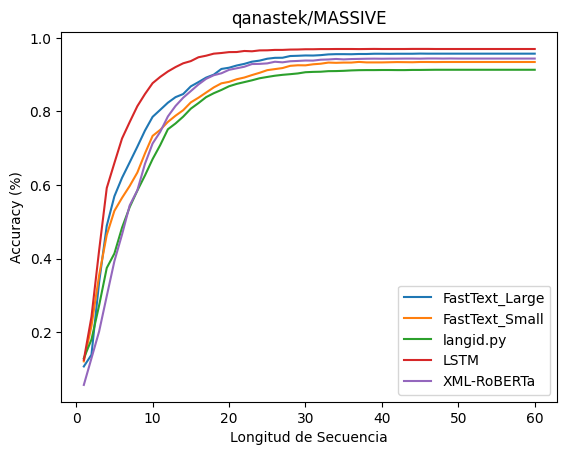

In [10]:
for result in results:
    result["num of char"] = [i+1 for i in range(60)]
    result["avg_acc"] = sum(result["accuracy"])/len(result["accuracy"])
    ax = sns.lineplot(result, y="accuracy", x="num of char", label=result["model"])
    ax.set_xlabel("Longitud de Secuencia")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("qanastek/MASSIVE")

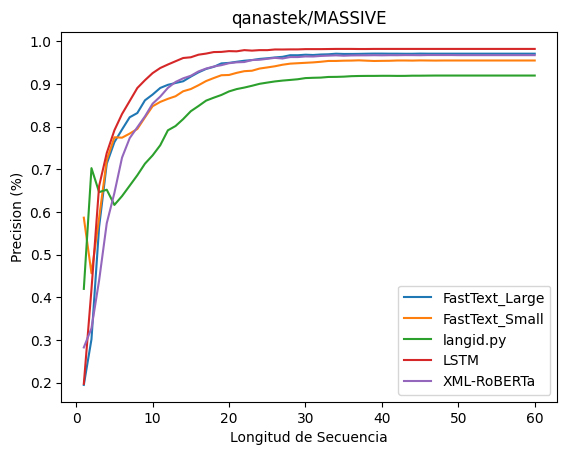

In [11]:
for result in results:
    result["num of char"] = [i+1 for i in range(60)]
    result["avg_precision"] = sum(result["precision"])/len(result["precision"])
    ax = sns.lineplot(result, y="precision", x="num of char", label=result["model"])
    ax.set_xlabel("Longitud de Secuencia")
    ax.set_ylabel("Precision (%)")
    ax.set_title("qanastek/MASSIVE")

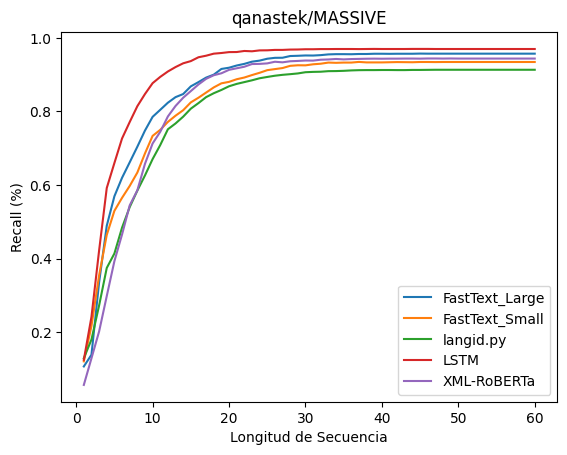

In [12]:
for result in results:
    result["num of char"] = [i+1 for i in range(60)]
    result["avg_recall"] = sum(result["recall"])/len(result["recall"])
    ax = sns.lineplot(result, y="recall", x="num of char", label=result["model"])
    ax.set_xlabel("Longitud de Secuencia")
    ax.set_ylabel("Recall (%)")
    ax.set_title("qanastek/MASSIVE")

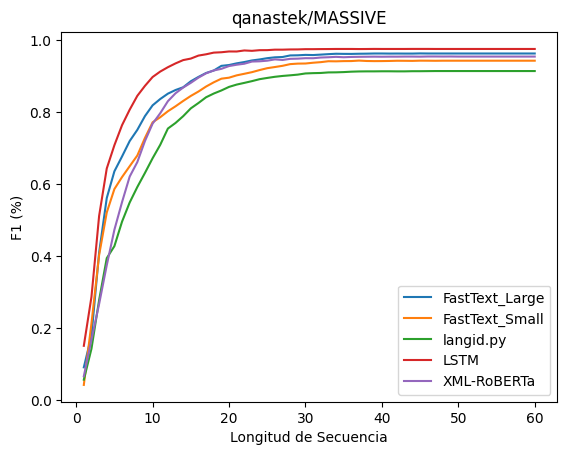

In [13]:
for result in results:
    result["num of char"] = [i+1 for i in range(60)]
    result["avg_f1"] = sum(result["f1"])/len(result["f1"])
    ax = sns.lineplot(result, y="f1", x="num of char", label=result["model"])
    ax.set_xlabel("Longitud de Secuencia")
    ax.set_ylabel("F1 (%)")
    ax.set_title("qanastek/MASSIVE")

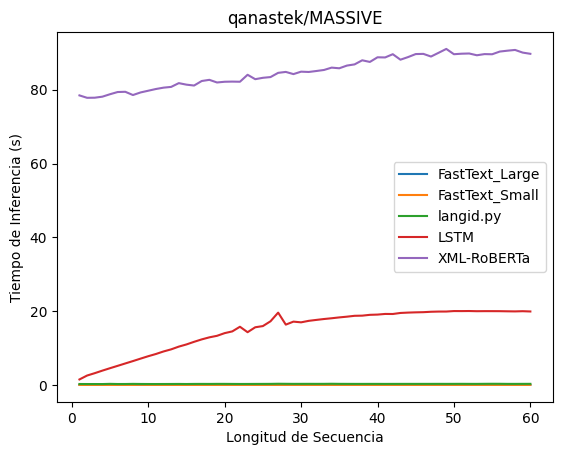

In [14]:
for result in results:
    result["num of char"] = [i+1 for i in range(60)]
    result["avg_inferenceTime"] = sum(result["inferenceTime"])/len(result["inferenceTime"])
    ax = sns.lineplot(result, y="inferenceTime", x="num of char", label=result["model"])
    ax.set_xlabel("Longitud de Secuencia")
    ax.set_ylabel("Tiempo de Inferencia (s)")
    ax.set_title("qanastek/MASSIVE")

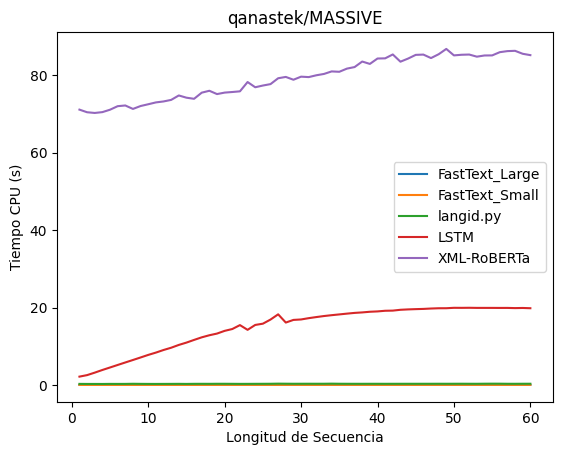

In [15]:
for result in results:
    result["num of char"] = [i+1 for i in range(60)]
    result["avg_cpu_time"] = sum(result["cpu_time"])/len(result["cpu_time"])
    ax = sns.lineplot(result, y="cpu_time", x="num of char", label=result["model"])
    ax.set_xlabel("Longitud de Secuencia")
    ax.set_ylabel("Tiempo CPU (s)")
    ax.set_title("qanastek/MASSIVE")

In [16]:
for result in results:
    print(f"{result["model"]} Final Result\n")
    print(result["classification_report"][-1])
    print("\n")

FastText_Large Final Result

              precision    recall  f1-score   support

         UNK       0.00      0.00      0.00         0
          de       0.98      0.98      0.98       500
          en       0.90      0.99      0.94       500
          es       0.92      0.96      0.94       500
          fr       0.97      0.98      0.97       500
          it       0.99      0.97      0.98       500
          nl       0.99      0.91      0.95       500
          tr       1.00      0.97      0.99       500
          pt       0.99      0.87      0.93       500
          pl       1.00      0.97      0.98       500

    accuracy                           0.96      4500
   macro avg       0.87      0.86      0.87      4500
weighted avg       0.97      0.96      0.96      4500



FastText_Small Final Result

              precision    recall  f1-score   support

         UNK       0.00      0.00      0.00         0
          de       0.97      0.97      0.97       500
          en      

Matriz de Confusion FastText_Large


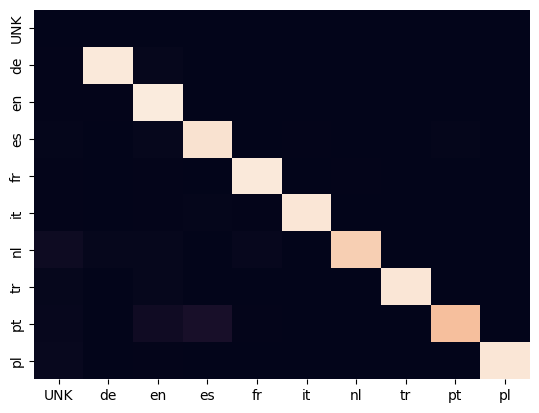

Matriz de Confusion FastText_Small


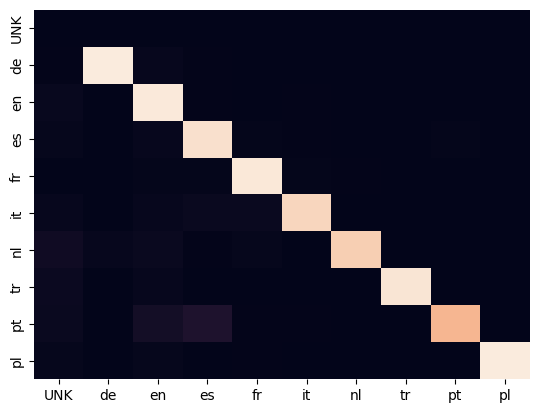

Matriz de Confusion langid.py


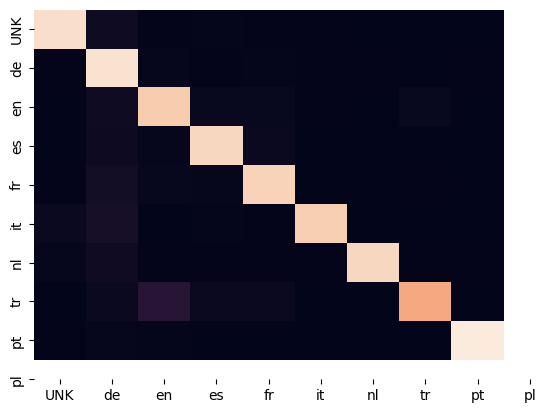

Matriz de Confusion LSTM


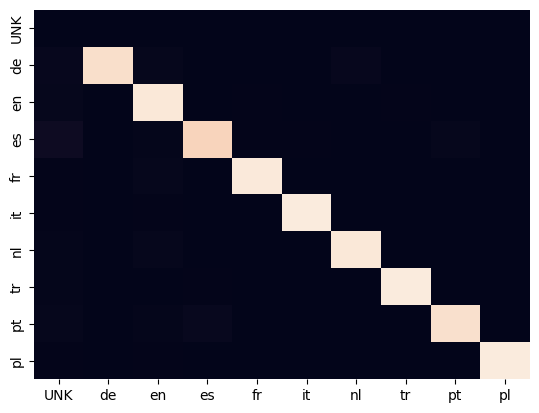

Matriz de Confusion XML-RoBERTa


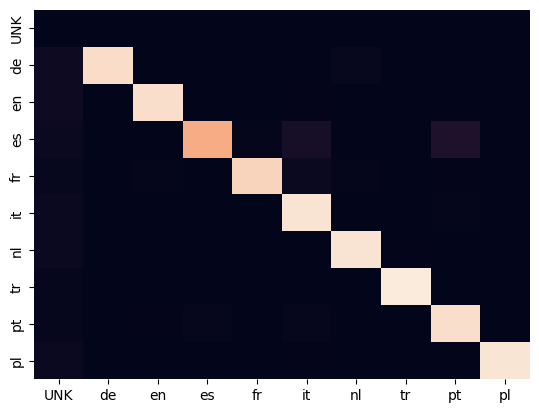

In [17]:
for result in results:
    print(f"Matriz de Confusion {result['model']}")
    cf_matrix = result["confusion_matrix"][-1]
    ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), cbar=False, xticklabels=langs, yticklabels=langs)
    plt.show()

In [18]:
for result in results:
    print(f"{result["model"]}\n")
    print("Final Accuracy: ", result["accuracy"][-1])
    print("Avg Accuracy: ", statistics.fmean(result["accuracy"]))
    print("\n")
    print("Final Precision: ", result["precision"][-1])
    print("Avg Precision: ", statistics.fmean(result["precision"]))
    print("\n")
    print("Final Recall: ", result["recall"][-1])
    print("Avg Recall: ", statistics.fmean(result["recall"]))
    print("\n")
    print("Final F1: ", result["f1"][-1])
    print("Avg F1: ", statistics.fmean(result["f1"]))
    print("\n")
    print("Avg Inference Time: ", statistics.fmean(result["inferenceTime"]))
    print("Total Inference Time: ", sum(result["inferenceTime"]))
    print("Avg CPU Time: ", statistics.fmean(result["cpu_time"]))
    print("\n--------------------------\n")

FastText_Large

Final Accuracy:  0.9571111111111111
Avg Accuracy:  0.8659703703703704


Final Precision:  0.9710163806052864
Avg Precision:  0.9111663187053836


Final Recall:  0.9571111111111111
Avg Recall:  0.8659703703703704


Final F1:  0.9631454563851511
Avg F1:  0.8815726908493626


Avg Inference Time:  0.01962760289510091
Total Inference Time:  1.1776561737060547
Avg CPU Time:  0.019271590399999164

--------------------------

FastText_Small

Final Accuracy:  0.9344444444444444
Avg Accuracy:  0.8377333333333333


Final Precision:  0.9550529806649221
Avg Precision:  0.9017672768399636


Final Recall:  0.9344444444444444
Avg Recall:  0.8377333333333333


Final F1:  0.9431124626147567
Avg F1:  0.8531082552539931


Avg Inference Time:  0.022215878963470458
Total Inference Time:  1.3329527378082275
Avg CPU Time:  0.021886933333334233

--------------------------

langid.py

Final Accuracy:  0.9133333333333333
Avg Accuracy:  0.8105703703703704


Final Precision:  0.9197692766745686
Avg

In [19]:
for result in results:
    print(f"\nPerformance Relativo de {result['model']} a FastText Large\n")
    print("Precision: ", -1*(1-(result["avg_precision"]/ft_l_results["avg_precision"])))
    print("Inference Time: ", -1*(1-(result["avg_inferenceTime"]/ft_l_results["avg_inferenceTime"])))


Performance Relativo de FastText_Large a FastText Large

Precision:  -0.0
Inference Time:  -0.0

Performance Relativo de FastText_Small a FastText Large

Precision:  -0.010315396511554997
Inference Time:  0.13186918862188635

Performance Relativo de langid.py a FastText Large

Precision:  -0.05981905265677445
Inference Time:  13.679401625444786

Performance Relativo de LSTM a FastText Large

Precision:  0.026337292837740334
Inference Time:  766.8518852713906

Performance Relativo de XML-RoBERTa a FastText Large

Precision:  -0.01141140715846356
Inference Time:  4327.884345173793
